In [105]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [106]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [107]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)
        
    def control(self, X, t):
        #g_des = (np.sin(0.05*t)+1)**4*np.sin(0.5*t)
        #g_des = np.sin(2*t)
        #g, d = X 
        #gain = 0.5
        u_g = 4*np.sin(2*t) #gain*(g_des-g)
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g # - 0.01*g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    # g = ground speed
    # d = distance
    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        # define all the sensors I want in the system to use for simulation
        # g = ground speed
        # d = distance
        y = np.array([g/d + self.v.rvs(g.shape), 
                      g + self.v.rvs(g.shape), 
                      d + self.v.rvs(d.shape),
                      2*g + self.v.rvs(g.shape),
                      2*d + self.v.rvs(g.shape),])
        return y
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [108]:
sys = MonoCamera()

x0 = np.array([5, 3]) # initial conditions
tsim = np.arange(0, 30, 0.01) # simulation  time

X, U, Y = sys.simulate(x0, tsim)

(0.0, 30.0)

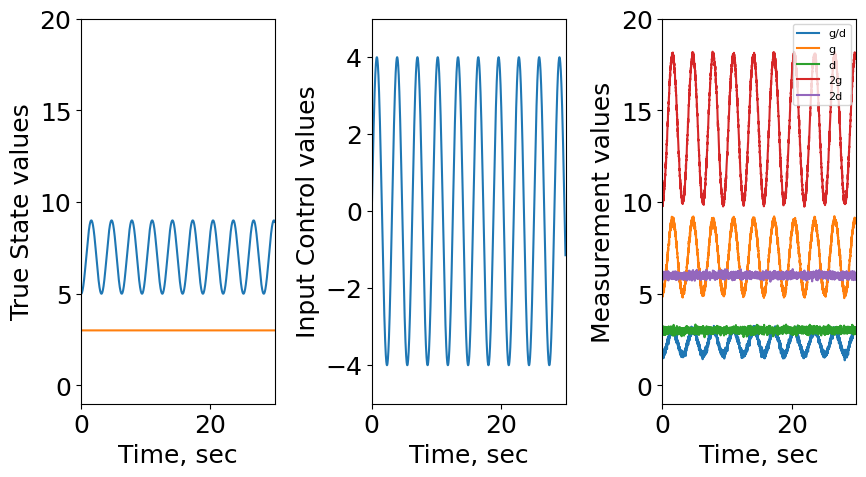

In [109]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('True State values')

ax.set_ylim([-1, 20])
ax.set_xlim([0, 30])

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Input Control values')

ax.set_ylim([-5, 5])
ax.set_xlim([0, 30])

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:], label='g/d')
ax.plot(tsim, Y[1,:], label='g')
ax.plot(tsim, Y[2,:], label='d')
ax.plot(tsim, Y[3,:], label='2g')
ax.plot(tsim, Y[4,:], label='2d')
#ax.plot(tsim, Y[1,:])

# legend on the right
ax.legend(loc='upper right', fontsize=8)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')
ax.set_ylim([-1, 20])
ax.set_xlim([0, 30])

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays. 

## Initial conditions
Set up the initial conditions for the EKF. 

In [110]:
# Initial conditions
x0 = np.array([[5], [2.5]])
P0 = 1000000*np.eye(2)

# Noise defined by measurement noise
R = sys.std**2*np.eye(5)

# Fairly accurate model
Q = 5e-4*np.eye(2)

In [111]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [112]:
import ekf

In [113]:
def f_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    g_dot = u # 0.01*g
    d_dot = 0
    x_new = np.atleast_2d(np.array([g + g_dot*dt, d + d_dot*dt])).T
    return x_new

def h_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    # define the sensors that I will be giving the EKF
    sensors = [np.array( [g/d] ), np.array(g), np.array(d), np.array(2*g), np.array(2*d)]
    y = np.atleast_2d(np.hstack(sensors)).T
    return y

Use a modified R matrix to determine which combinations of sensors will be used by the EKF. Really large element of R means that the EKF will essentially ignore that sensor. According to Austin at least...

In [114]:
import itertools

numbers = [0, 1, 2, 3, 4]
all_combinations = []

# Generate combinations of length 1 to 5
for r in range(1, len(numbers) + 1):
    combs = list(itertools.combinations(numbers, r))
    all_combinations.extend(combs)

R_modified = []

for r in range(1, 6):
    for combo in itertools.combinations(range(5), r):
        matrix = R.copy()
        
        # Set large number for diagonals NOT in the combo
        for i in range(5):
            if i not in combo:
                matrix[i, i] = 1e20
        
        R_modified.append(matrix)

# Print results
for i in range(len(R_modified)):
    print(R_modified[i])
    print()



[[1.e-02 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+20]]

[[1.e+20 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+20]]

[[1.e+20 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+20]]

[[1.e+20 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e+20]]

[[1.e+20 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e-02 0.e+00 0.e+00 0.e+00 0.e+00]
 [

In [115]:
import pandas as pd

results = [pd.DataFrame(columns = ['x0_hat', 'x1_hat', 'P0', 'P1', 's0', 's1']) for _ in range(len(R_modified))]

for i in range(len(R_modified)):
    R = R_modified[i]
    # run the EKF
    xhat, P, s = ekf.ekf(Y, x0, f_d, h_d, Q, R, U)
    results[i]['x0_hat'] = xhat[0, :]
    results[i]['x1_hat'] = xhat[1, :]
    results[i]['P0'] = P[0, 0, :]
    results[i]['P1'] = P[1, 1, :]
    results[i]['s0'] = s[0, :]
    results[i]['s1'] = s[1, :]

# xhat, P, s = ekf.ekf(Y, x0, f_d, h_d, Q, R, U)
# print(xhat.shape)
# print(P.shape)
# print(s.shape)

## Plot Results
Plot the results of the EKF without considering the 3 sigma bounds. 

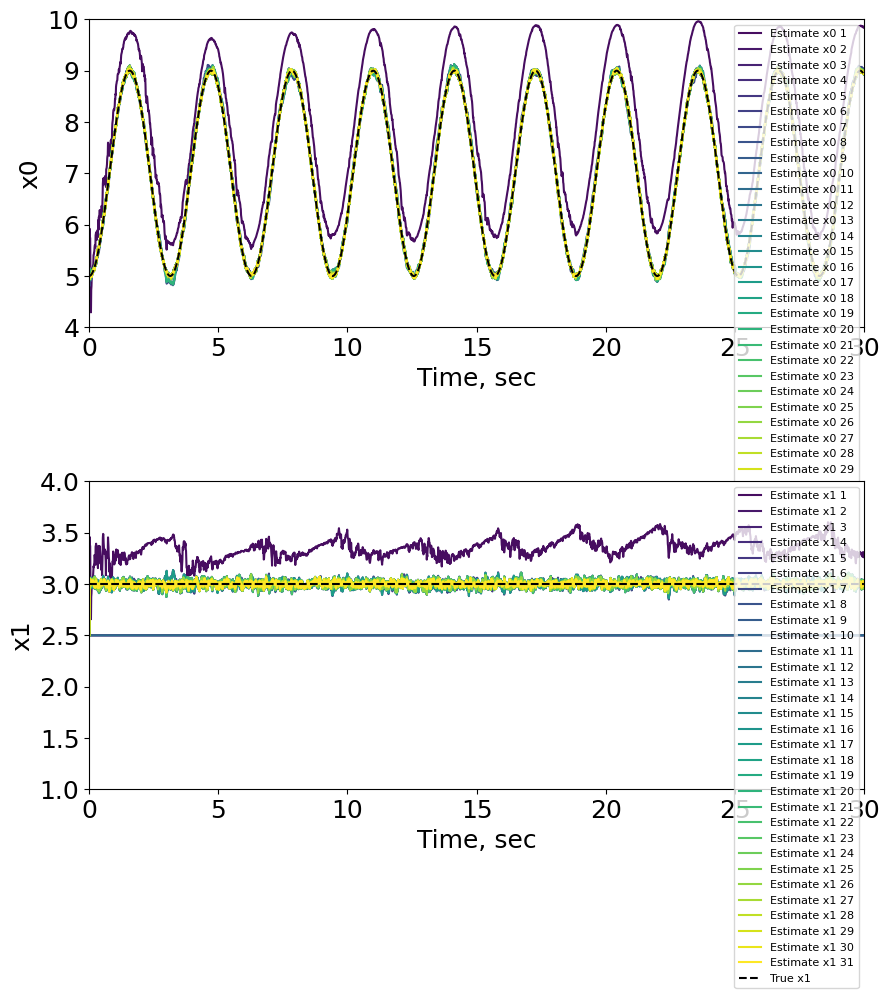

In [116]:
# plot the results using 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)
# plot all 31 estimates of x0

# define a color map for the lines
cmap = plt.get_cmap('viridis', len(R_modified)+1)

for i in range(len(R_modified)):
    axs[0].plot(tsim, results[i]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([4, 10])
axs[0].set_xlim([0, 30])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')

# legend
axs[0].legend(loc='upper right', fontsize=8)

# plot all 31 estimates of x1
for i in range(len(R_modified)):
    axs[1].plot(tsim, results[i]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([1, 4])
axs[1].set_xlim([0, 30])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)

plt.show()


# Cramer Rao Bound

### numerical jacobian

Maybe could be more efficient using ``jax``?

In [117]:
def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.matrix(np.vstack(Aj)), np.matrix(np.vstack(Bj))

### cramer rao bound

In [127]:
inv = np.linalg.inv

# invJk_diags = []
# Jk = inv(P0)
# for i in range(len(tsim)):
#     xhat_i = xhat[:,i]
#     u_i = U[:,i]
    
#     A, B = jacobian(f_d, np.ravel(xhat_i), np.ravel(u_i))
#     C, D = jacobian(h_d, np.ravel(xhat_i), np.ravel(u_i))
    
#     Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(R)@C
    
#     invJk_diags.append(np.diag( inv(Jk)) )

# calcualte inverse of Jk for each time step and for all snesor combinations
# add a column for invJk_diags in the results dataframe
for i in range(len(R_modified)):
    results[i]['invJk_diags'] = np.nan
    Jk = inv(P0)
    for j in range(len(tsim)):
        this_xhat = np.array([results[i]['x0_hat'][j], results[i]['x1_hat'][j]])
        this_u = U[:,j]

        A, B = jacobian(f_d, np.ravel(this_xhat), np.ravel(this_u))
        C, D = jacobian(h_d, np.ravel(this_xhat), np.ravel(this_u))

        Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(R)@C
        print(np.diag( inv(Jk) ))
        results[i]['invJk_diags'][j] = np.array(np.diag( inv(Jk) ))

[0.00194482 0.00177947]


ValueError: setting an array element with a sequence.

In [ ]:
CRB = np.vstack(invJk_diags).T

### show CRB

Red dashed lines are 3-sigma bounds determined by the KF.
Gray shading is the 3-sigma CRB bound. 

(0.0, 4.0)

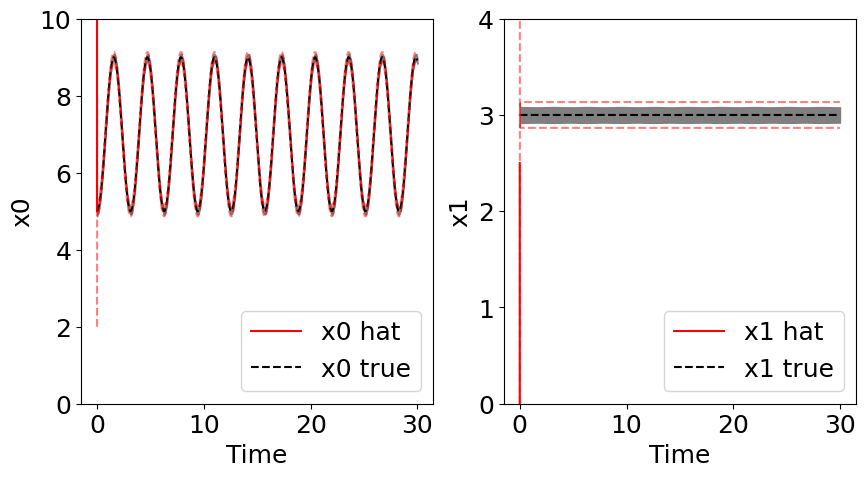

In [ ]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
plot_tme(tsim, X[0,:].T, None, xhat[0,:].T, ax=ax, label_var='x0')
ax.plot(tsim, 3*P[0,0,:]**0.5+X[0,:].T, '--', color='red', alpha=0.5)
ax.plot(tsim, -3*P[0,0,:]**0.5+X[0,:].T, '--', color='red', alpha=0.5)
ax.fill_between(tsim, X[0,:].T+3*CRB[0,:]**0.5, X[0,:].T-3*CRB[0,:]**0.5, color='gray', zorder=-100)
ax.set_ylim(0, 10)


ax = fig.add_subplot(122)
plot_tme(tsim, X[1,:].T, None, xhat[1,:].T, ax=ax, label_var='x1')
ax.plot(tsim, 3*P[1,1,:]**0.5+X[1,:].T, '--', color='red', alpha=0.5)
ax.plot(tsim, -3*P[1,1,:]**0.5+X[1,:].T, '--', color='red', alpha=0.5)
ax.fill_between(tsim, X[1,:].T+3*CRB[1,:]**0.5, X[1,:].T-3*CRB[1,:]**0.5, color='gray', zorder=-100)
ax.set_ylim(0,4)